# Lab 7: SNNs

Ryan Schaefer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, Concatenate, Subtract, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.random.set_seed(7324)
np.random.seed(7324)

# Business Case

Dataset source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Data Preparation

## Load Data

In [2]:
df_fake = pd.read_csv("../Datasets/fake_news/Fake.csv")
df_fake["real_news"] = 0
df_fake["label"] = "Fake"

df_real = pd.read_csv("../Datasets/fake_news/True.csv")
df_real["real_news"] = 1
df_real["label"] = "Real"

labels = ["Fake", "Real"]
df = pd.concat([df_fake, df_real]).reset_index(drop = True)
df

,title,text,subject,date,real_news,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Fake
...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1,Real
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1,Real
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1,Real
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1,Real


In [3]:
X_text = np.array(df["text"])
y = np.array(df["real_news"])

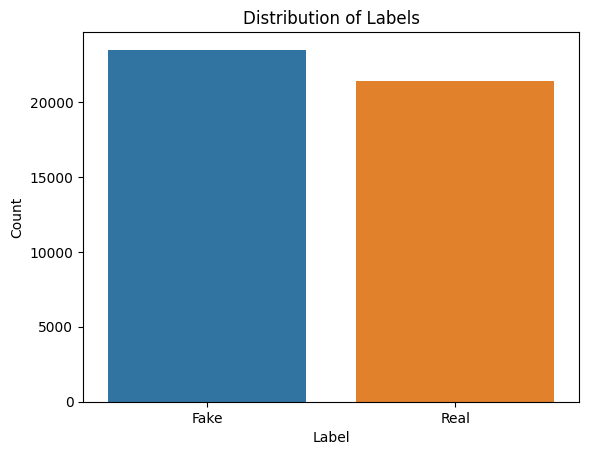

In [4]:
sns.countplot(df, x = "label")

plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")

plt.show()

## Tokenization

In [5]:
%%time

NUM_TOP_WORDS = None # use entire vocabulary!

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 138021 unique tokens. Distilled to 138021 top words.
CPU times: user 10.3 s, sys: 153 ms, total: 10.4 s
Wall time: 9.98 s


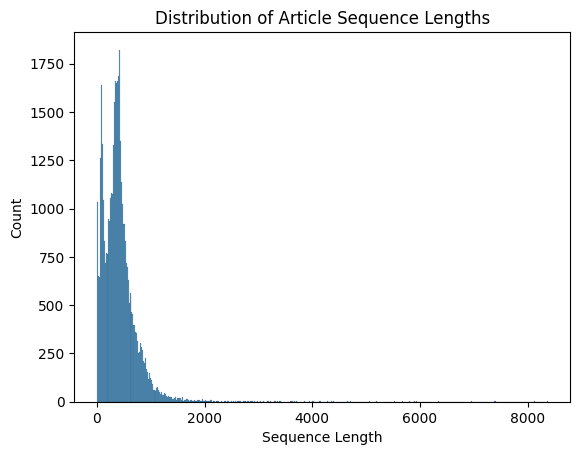

In [6]:
sequence_lengths = list(map(lambda x: len(x), sequences))

sns.histplot(sequence_lengths)

plt.title("Distribution of Article Sequence Lengths")
plt.xlabel("Sequence Length")

plt.show()

In [7]:
MAX_ART_LEN = 2000 # maximum and minimum number of words
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Shape of data tensor: (44898, 2000)
Shape of label tensor: (44898,)
138021


## Evaluation Criteria

## Training/Testing Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=7324
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (35918, 2000)
Testing shape: (8980, 2000)


# Modeling

## GloVe Embeddings

In [9]:
%%time

EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../Datasets/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (138022, 100) 
 Total words found: 77226 
 Percentage: 55.95194968917998
CPU times: user 3.58 s, sys: 174 ms, total: 3.75 s
Wall time: 3.8 s


In [10]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## Model 1 (CNN, Parameter Set 1)

In [11]:
EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model1 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
# Let's train the model 
model1.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 100)         13802200  
                                                                 
 conv1d (Conv1D)             (None, 1996, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 399, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 399, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 395, 128)          82048     
                                                             

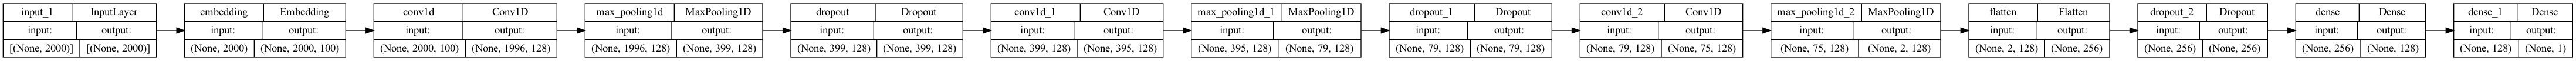

In [12]:
plot_model(
    model1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [13]:
%%time

history1 = []
hist1 = model1.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history1.append(hist1)

Epoch 1/5
281/281 [==============================] - 85s 300ms/step - loss: 0.2505 - precision: 0.8384 - val_loss: 0.1268 - val_precision: 0.8777
Epoch 2/5
281/281 [==============================] - 83s 297ms/step - loss: 0.1246 - precision: 0.8765 - val_loss: 0.1252 - val_precision: 0.8783
Epoch 3/5
281/281 [==============================] - 83s 295ms/step - loss: 0.1214 - precision: 0.8770 - val_loss: 0.1286 - val_precision: 0.8777
Epoch 4/5
281/281 [==============================] - 85s 302ms/step - loss: 0.1218 - precision: 0.8771 - val_loss: 0.1281 - val_precision: 0.8783
Epoch 5/5
281/281 [==============================] - 83s 295ms/step - loss: 0.1200 - precision: 0.8771 - val_loss: 0.1308 - val_precision: 0.8775
CPU times: user 51min 16s, sys: 5min 21s, total: 56min 38s
Wall time: 6min 58s


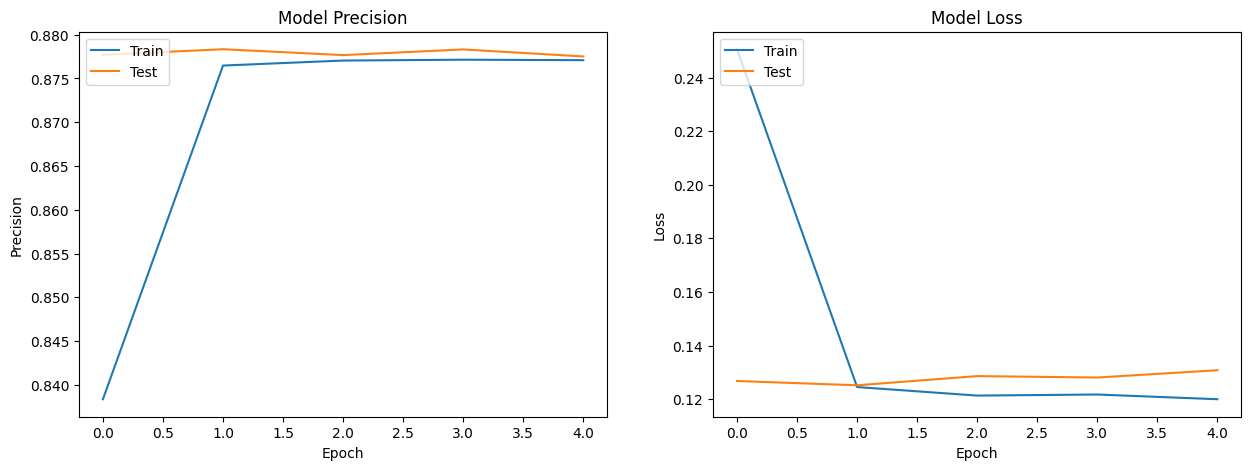

In [14]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [15]:
def compare_models(y, yhat):
    num_models = len(yhat)
    if num_models > 2:
        num_rows = 2
        plt.figure(figsize = (15, 10))
    else:
        num_rows = 1
        plt.figure(figsize = (15, 5))
    num_cols = num_models // num_rows
    if num_rows * num_cols < num_models:
        num_cols += 1
    for i in range(num_models):
        acc = mt.accuracy_score(y, yhat[i])
        precision = mt.precision_score(y, yhat[i])
        plt.subplot(num_rows, num_cols, i+1)
        cm = mt.confusion_matrix(y, yhat[i])
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.4f', xticklabels=labels, yticklabels=labels)
        plt.title(f'Model {i+1}: Accuracy = {acc:.4f}, Precision = {precision:.4f}')
        plt.xlabel("Predicted Class")
        plt.ylabel("Actual Class")

In [16]:
model1_proba = model1.predict(X_test)
model1_pred = np.round(list(map(lambda x: x[0], model1_proba)))

281/281 [==============================] - 7s 25ms/step


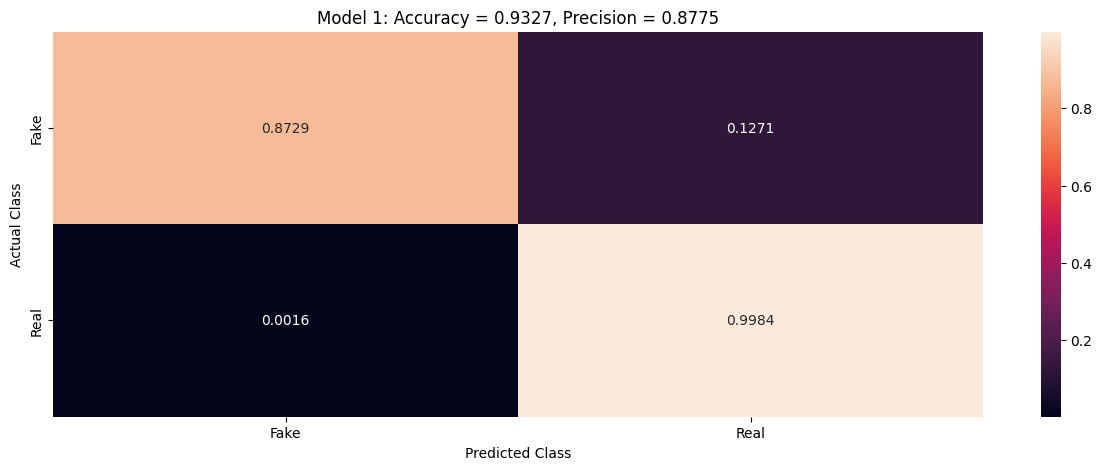

In [17]:
compare_models(y_test, [model1_pred])

## Model 2 (CNN, Parameter Set 2)

In [18]:
EMBED_SIZE = 100  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 35 elements long
x = MaxPooling1D(35)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)
# Added an additional dense layer
x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
# Let's train the model 
model2.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 100)         13802200  
                                                                 
 conv1d_3 (Conv1D)           (None, 1996, 64)          32064     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 399, 64)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 399, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 395, 64)           20544     
                                                           

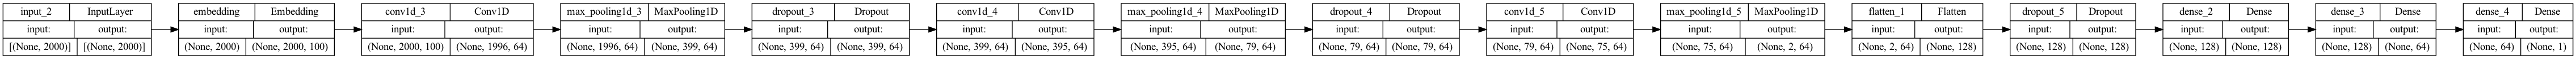

In [19]:
plot_model(
    model2, to_file='model2.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [20]:
%%time

history2 = []
hist2 = model2.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5, batch_size=128
)
history2.append(hist2)

Epoch 1/5
281/281 [==============================] - 50s 178ms/step - loss: 0.2366 - precision: 0.8322 - val_loss: 0.1293 - val_precision: 0.8777
Epoch 2/5
281/281 [==============================] - 50s 179ms/step - loss: 0.1255 - precision: 0.8768 - val_loss: 0.1282 - val_precision: 0.8773
Epoch 3/5
281/281 [==============================] - 50s 178ms/step - loss: 0.1230 - precision: 0.8766 - val_loss: 0.1280 - val_precision: 0.8775
Epoch 4/5
281/281 [==============================] - 50s 178ms/step - loss: 0.1218 - precision: 0.8770 - val_loss: 0.1287 - val_precision: 0.8780
Epoch 5/5
281/281 [==============================] - 50s 179ms/step - loss: 0.1214 - precision: 0.8770 - val_loss: 0.1287 - val_precision: 0.8778
CPU times: user 25min 47s, sys: 4min 30s, total: 30min 17s
Wall time: 4min 11s


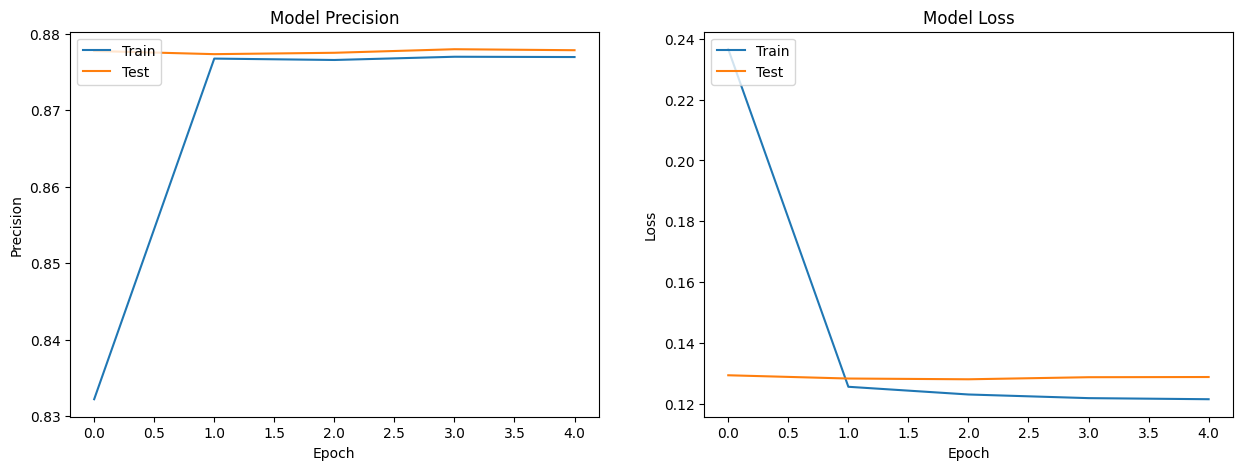

In [21]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [22]:
model2_proba = model2.predict(X_test)
model2_pred = np.round(list(map(lambda x: x[0], model2_proba)))

281/281 [==============================] - 4s 13ms/step


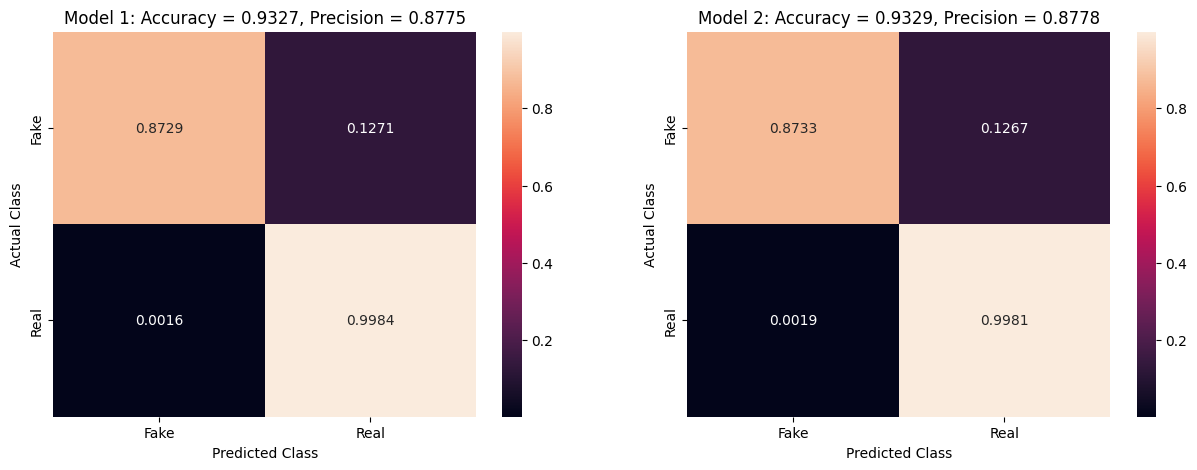

In [23]:
compare_models(y_test, [model1_pred, model2_pred])

## Model 3 (Transformer, Parameter Set 1)

In [24]:
# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

In [25]:
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [29]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model3 = Model(inputs=inputs, outputs=preds)

model3.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[Precision(name = "precision")]
)

model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2000)]            0         
                                                                 
 glove_token_and_position_e  (None, 2000, 100)         14002200  
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 2000, 100)         87632     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 100)               0   

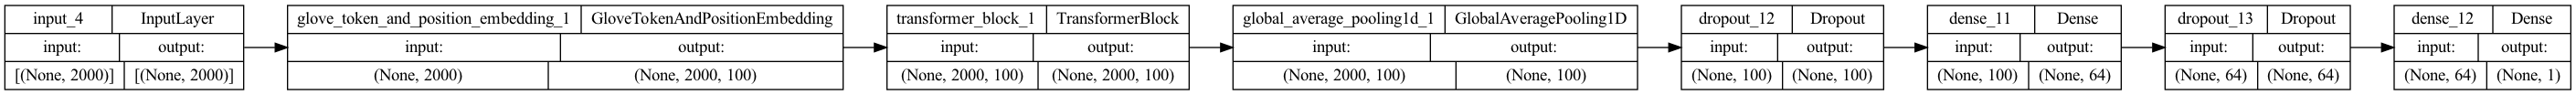

In [30]:
plot_model(
    model3, to_file='model3.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [31]:
%%time

history3 = []
hist3 = model3.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=2, batch_size=128
)
history3.append(hist3)

Epoch 1/2
  8/281 [..............................] - ETA: 1:38:58 - loss: 0.7629 - precision: 0.4667

KeyboardInterrupt: 

In [32]:
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history3])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


ValueError: need at least one array to concatenate

In [ ]:
model3_proba = model3.predict(X_test)
model3_pred = np.round(list(map(lambda x: x[0], model3_proba)))

In [ ]:
compare_models(y_test, [model1_pred, model2_pred, model3_pred])

## Model 4 (Transformer, Parameter Set 1)